<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

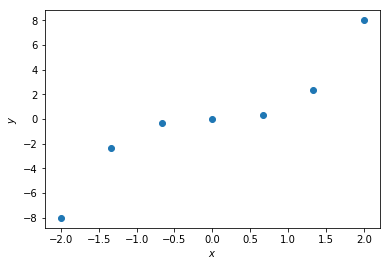

In [13]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

[[-2.        ]
 [-1.33333333]
 [-0.66666667]
 [ 0.        ]
 [ 0.66666667]
 [ 1.33333333]
 [ 2.        ]]
[-8.         -2.37037037 -0.2962963   0.          0.2962963   2.37037037
  8.        ]


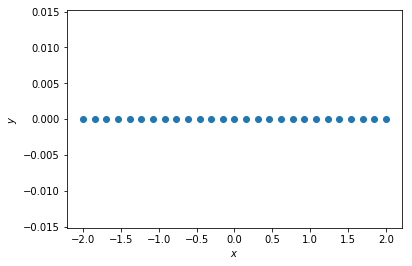

In [14]:
# Ваш код здесь
reg_tree = DecisionTreeClassifier(max_depth=1, random_state=17)
print(X.reshape(-1,1))
print(y)
reg_tree.fit(X.reshape(-1,1), np.zeros(X.shape[0]))
test_X = np.linspace(-2, 2, 27)
predictions = reg_tree.predict(test_X.reshape(-1, 1))
plt.scatter(test_X, predictions)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

[[-2.        ]
 [-1.33333333]
 [-0.66666667]
 [ 0.        ]
 [ 0.66666667]
 [ 1.33333333]
 [ 2.        ]]
[-8.         -2.37037037 -0.2962963   0.          0.2962963   2.37037037
  8.        ]


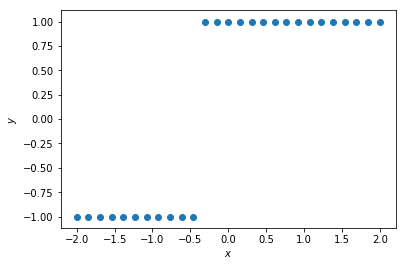

In [15]:
# Ваш код здесь
reg_tree = DecisionTreeClassifier(max_depth=1, random_state=17)
print(X.reshape(-1,1))
print(y)
reg_tree.fit(X.reshape(-1,1), np.sign(y))
test_X = np.linspace(-2, 2, 27)
predictions = reg_tree.predict(test_X.reshape(-1, 1))
plt.scatter(test_X, predictions)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [16]:
def regression_var_criterion(X, y, t):
    index_left = np.where(X < t)
    index_rigth = np.where(X >= t)
    X_l = X[index_left]
    y_l = y[index_left]
    X_r = X[index_rigth]
    y_r = y[index_rigth]
    
    Q = y.var() - y_l.var() * (X_l.shape[0]/X.shape[0]) - y_r.var() * (X_r.shape[0]/X.shape[0])
    return Q

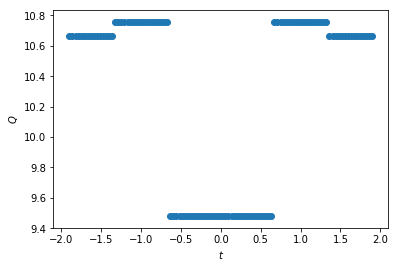

In [17]:
# Ваш код здесь
regression_var_criterion(X, y, 0)
Q = []
for t in np.linspace(-1.9, 1.9, 100):
    Q.append(regression_var_criterion(X, y, t))
plt.scatter(np.linspace(-1.9, 1.9, 100), Q)
plt.xlabel(r'$t$')
plt.ylabel(r'$Q$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

[[-2.        ]
 [-1.33333333]
 [-0.66666667]
 [ 0.        ]
 [ 0.66666667]
 [ 1.33333333]
 [ 2.        ]]
[-8.         -2.37037037 -0.2962963   0.          0.2962963   2.37037037
  8.        ]


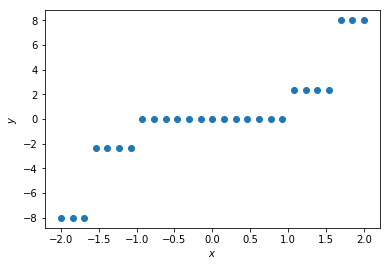

In [18]:
# Ваш код здесь
reg_tree = DecisionTreeRegressor(max_depth=3, random_state=17)
print(X.reshape(-1,1))
print(y)
reg_tree.fit(X.reshape(-1,1), y)
test_X = np.linspace(-2, 2, 27)
predictions = reg_tree.predict(test_X.reshape(-1, 1))
plt.scatter(test_X, predictions)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [19]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [20]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [21]:
# Ваш код здесь
df['age_years'] = (df['age'] // 365.25).astype(int)
df = pd.concat([df,
                pd.get_dummies(df['gluc'], prefix='gluc'),
                pd.get_dummies(df['cholesterol'], prefix='cholesterol')],
               axis=1)

In [22]:
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,gluc_1,gluc_2,gluc_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,1,0,0,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,1,0,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,1,0,0,1,0,0
8,21914,1,151,67.0,120,80,2,2,0,0,0,0,59,0,1,0,0,1,0
9,22113,1,157,93.0,130,80,3,1,0,0,1,0,60,1,0,0,0,0,1
12,22584,2,178,95.0,130,90,3,3,0,0,1,1,61,0,0,1,0,0,1
13,17668,1,158,71.0,110,70,1,1,0,0,1,0,48,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [23]:
df.drop(["cardio"], axis=1).head(1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,gluc_1,gluc_2,gluc_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,50,1,0,0,1,0,0


In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop(["cardio"], axis=1),
    df["cardio"],
    test_size=0.7,
    random_state=17)

In [32]:
X_train.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'age_years', 'gluc_1', 'gluc_2',
       'gluc_3', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3'],
      dtype='object')

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

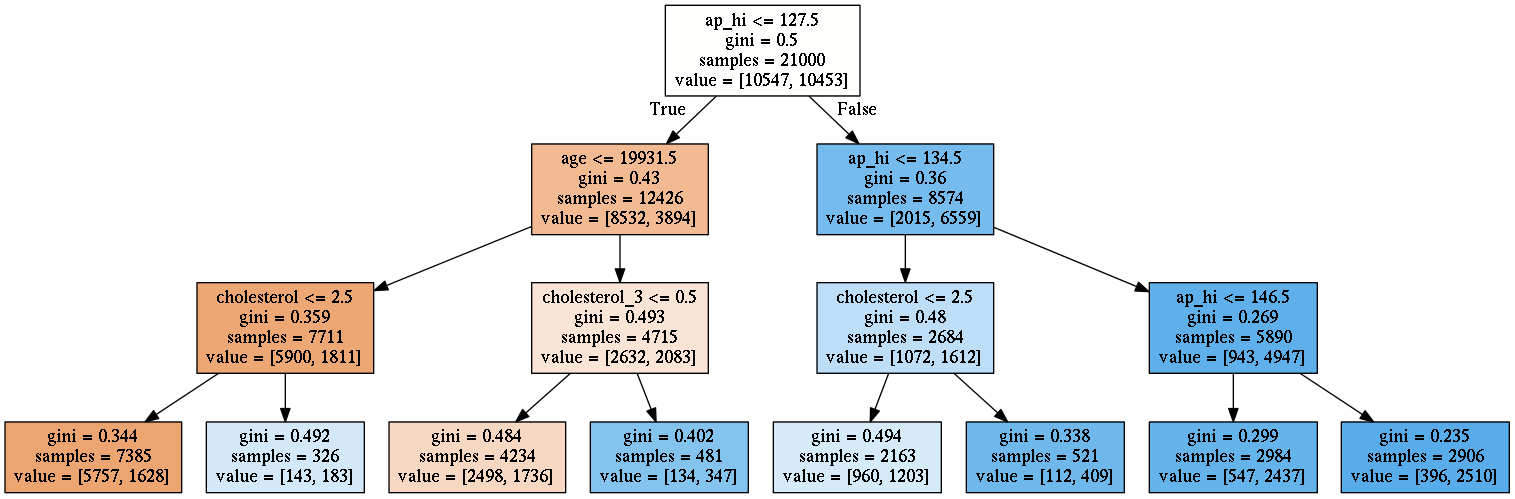

In [42]:
# Ваш код здесь

reg_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
reg_tree.fit(X_train, y_train)
export_graphviz(reg_tree,  feature_names=X_train.columns,
out_file='../../img/cardio.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
import pydot
!dot -Tpng '../../img/cardio.dot' -o '../../img/cardio.png'
from IPython.display import Image
Image(filename='../../img/cardio.png') 

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [43]:
# Ваш код здесь
import sys
sys.path
import pydot
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'
#Image(filename='../../img/small_tree.png')
predictions = reg_tree.predict(X_valid)

#accuracy_score(y_valid, predictions)

In [45]:
#print(predictions)
#print(y_valid)
accuracy_score(y_valid, predictions)

0.72338775510204079

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [48]:
tree_params = {'max_depth': list(range(2, 11))}


tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params,
cv=5, n_jobs=-1,
verbose=True)
tree_grid.fit(X_train, y_train)
tree_grid.best_params_
tree_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished


0.73242857142857143

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

{'max_depth': 4}
0.732428571429


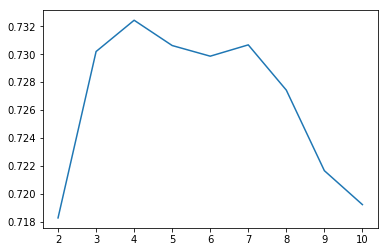

In [63]:
# Ваш код здесь
print(tree_grid.best_params_)
print(tree_grid.best_score_)
accuracy_score(y_valid, tree_grid.predict(X_valid))

plt.plot(list(range(2, 11)), tree_grid.cv_results_["mean_test_score"])


Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [66]:
# Ваш код здесь
print(accuracy_score(y_valid, predictions))
print(tree_grid.best_score_)
print((accuracy_score(y_valid, predictions) - tree_grid.best_score_) / tree_grid.best_score_)

0.723387755102
0.732428571429
-0.0123436150352


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [82]:
# Ваш код здесь
for i in [45, 50, 55, 60]:
    df["region_age_{}".format(i)] = (df['age_years'] >= i) & (df['age_years'] < i+5)
    df["region_age_{}".format(i)] = df["region_age_{}".format(i)].astype(int)



In [83]:
for i in [120, 140, 160]:
    df["region_ap_hi_{}".format(i)] = (df['ap_hi'] >= i) & (df['ap_hi'] < i+20)
    df["region_ap_hi_{}".format(i)] = df["region_ap_hi_{}".format(i)].astype(int)


In [84]:
df["male"] = df["gender"] - 1

In [85]:
finish_tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [89]:
list_ = []
for i in [45, 50, 55, 60]:
    list_.append("region_age_{}".format(i))
for i in [120, 140, 160]:
    list_.append("region_ap_hi_{}".format(i))
for i in [1, 2, 3]:
    list_.append("cholesterol_{}".format(i))
list_.extend(['male', 'smoke'])
len(list_)
#finish_tree.fit()

12

In [91]:
finish_tree.fit(df[list_], df["cardio"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

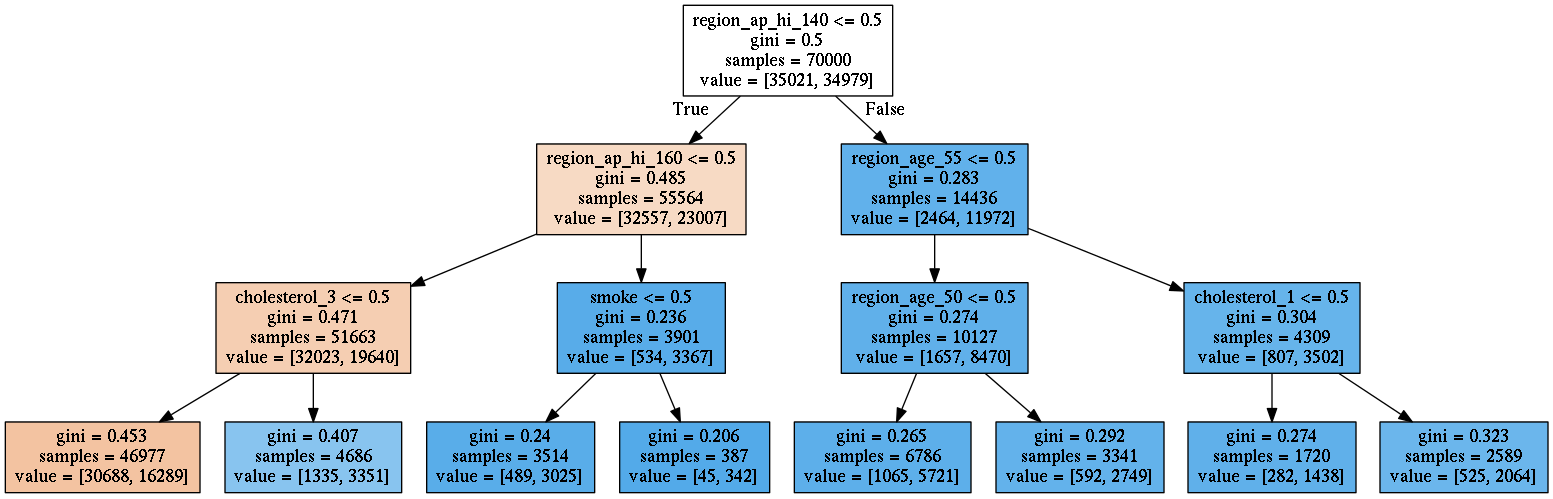

In [93]:
export_graphviz(finish_tree,  feature_names=list_,
out_file='../../img/finish_cardio.dot', filled=True)
!dot -Tpng '../../img/finish_cardio.dot' -o '../../img/finish_cardio.png'
Image(filename='../../img/finish_cardio.png')
